In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import requests
from bs4 import BeautifulSoup
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import gensim
from gensim import corpora, models

import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity

import yake
from sentence_transformers import SentenceTransformer
from transformers import pipeline

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sanketpatil/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sanketpatil/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
#article fetching 
URL = "https://www.frontiersin.org/journals/sustainable-cities/articles/10.3389/frsc.2023.1308684/full"
resp = requests.get(URL, timeout=30)
resp.raise_for_status()
soup = BeautifulSoup(resp.text, "lxml")

#exstracticng tge paragrapgh text
paragraphs = [p.get_text().strip() for p in soup.find_all("p") if p.get_text().strip()]
print(f"Number of paragraphs extracted: {len(paragraphs)}")

#joing all to one large topic modelling
text = " ".join(paragraphs)

#text cleaning
text = re.sub(r'\s+', ' ', text)

#tokenize into sentences
sentences = sent_tokenize(text)

#
stop_words = set(stopwords.words("english"))
tokens = [
    [w.lower() for w in word_tokenize(s)
     if w.isalpha() and w.lower() not in stop_words]
    for s in sentences
]

#removing the tokens 
tokens = [t for t in tokens if t]

print(f"Number of sentences tokenized: {len(tokens)}")

Number of paragraphs extracted: 517
Number of sentences tokenized: 1239


In [18]:

dictionary = corpora.Dictionary(tokens)
dictionary.filter_extremes(no_below=4, no_above=0.5)
corpus = [dictionary.doc2bow(t) for t in tokens]
print("Vocabulary size:", len(dictionary))

NUM_TOPICS = 7

Vocabulary size: 600


In [19]:
# LDA model
lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    passes=12,
    iterations=100,
    random_state=43
)

print("\nLDA Topics")
for i in range(NUM_TOPICS):
    print(f"Topic {i+1}: {lda_model.print_topic(i, topn=10)}")


LDA Topics
Topic 1: 0.034*"india" + 0.019*"et" + 0.019*"due" + 0.016*"risk" + 0.014*"particularly" + 0.013*"growth" + 0.013*"climate" + 0.011*"review" + 0.011*"emissions" + 0.011*"impacts"
Topic 2: 0.032*"climate" + 0.026*"environ" + 0.022*"change" + 0.021*"sci" + 0.014*"impacts" + 0.013*"nbs" + 0.013*"et" + 0.011*"environmental" + 0.011*"india" + 0.011*"sustainable"
Topic 3: 0.147*"google" + 0.146*"scholar" + 0.099*"full" + 0.098*"doi" + 0.097*"text" + 0.097*"crossref" + 0.019*"al" + 0.019*"et" + 0.016*"sonwani" + 0.013*"saxena"
Topic 4: 0.052*"climate" + 0.034*"change" + 0.023*"india" + 0.021*"et" + 0.018*"global" + 0.018*"report" + 0.014*"forest" + 0.012*"vulnerability" + 0.012*"extreme" + 0.012*"forests"
Topic 5: 0.032*"air" + 0.028*"india" + 0.022*"pollution" + 0.018*"cities" + 0.017*"heat" + 0.016*"urban" + 0.016*"emissions" + 0.015*"water" + 0.015*"health" + 0.014*"energy"
Topic 6: 0.053*"et" + 0.045*"pubmed" + 0.045*"abstract" + 0.042*"urban" + 0.018*"green" + 0.017*"temperatu

In [20]:
# LSI model
lsi_model = models.LsiModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS
)

print("\nLSI Topics")
for i in range(NUM_TOPICS):
    print(f"LSI topic {i+1}: {lsi_model.print_topic(i, topn=10)}")


LSI Topics
LSI topic 1: -0.444*"google" + -0.443*"scholar" + -0.373*"full" + -0.372*"doi" + -0.372*"text" + -0.372*"crossref" + -0.105*"pubmed" + -0.105*"abstract" + -0.104*"et" + -0.065*"al"
LSI topic 2: -0.666*"climate" + -0.490*"change" + -0.286*"india" + -0.216*"et" + -0.127*"urban" + -0.118*"air" + -0.100*"pollution" + -0.095*"impacts" + -0.091*"impact" + -0.083*"cities"
LSI topic 3: -0.833*"et" + 0.256*"climate" + 0.226*"change" + -0.163*"sonwani" + -0.130*"urban" + -0.117*"air" + -0.108*"al" + -0.092*"like" + -0.085*"temperatures" + -0.068*"pollution"
LSI topic 4: -0.803*"india" + -0.288*"urban" + 0.240*"change" + 0.189*"climate" + 0.162*"et" + -0.122*"emissions" + 0.091*"air" + -0.076*"temperature" + 0.071*"pollution" + -0.066*"areas"
LSI topic 5: 0.578*"air" + 0.439*"pollution" + 0.318*"urban" + -0.238*"et" + 0.190*"health" + 0.184*"green" + -0.133*"climate" + 0.131*"infrastructure" + -0.127*"india" + 0.116*"cities"
LSI topic 6: 0.658*"urban" + -0.352*"air" + -0.303*"india" +

In [21]:
#clustering
topic_vectors = np.array([
    [prob for (_, prob) in lda_model.get_document_topics(bow, minimum_probability=0.0)]
    for bow in corpus
])

print("Topic vectors shape:", topic_vectors.shape)

Topic vectors shape: (1239, 7)


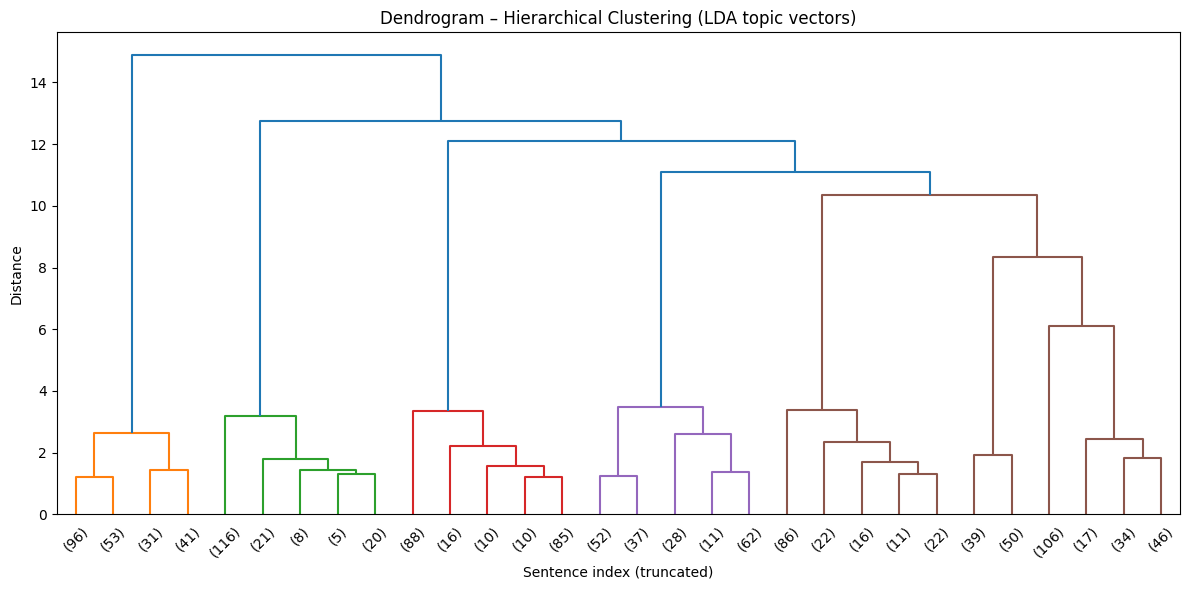

In [22]:
#removal of unncesary sentences
nonzero_mask = ~(np.all(topic_vectors == 0, axis=1))
tv = topic_vectors[nonzero_mask]


Z = linkage(tv, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=30)
plt.title("Dendrogram – Hierarchical Clustering (LDA topic vectors)")
plt.xlabel("Sentence index (truncated)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [23]:
#using llm to summerize  main topic
llm = pipeline("text-generation", model="gpt2", tokenizer="gpt2")

prompt = (
    "Please summarise the main topics of the following article in 5 bullet points:\n\n"
    + text[:4000]  # Use first 4000 characters
)

llm_out = llm(
    prompt, 
    max_length=200, 
    max_new_tokens=250,
    do_sample=False
)[0]['generated_text']

print("\nLLM Summarised Topics")
print(llm_out)

Device set to use mps:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Both `max_new_tokens` (=250) and `max_length`(=200) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)



LLM Summarised Topics
Please summarise the main topics of the following article in 5 bullet points:

Your new experience awaits. Try the new design now and help us make it even better REVIEW article Front. Sustain. Cities, 11 January 2024 Sec. Climate Change and Cities Volume 5 - 2023 | https://doi.org/10.3389/frsc.2023.1308684 This article is part of the Research TopicTowards 2030: A Sustainable Cities Perspective on Achieving Sustainable Development Goal 13 – Climate ActionView all 7 articles Climate change is a global concern of the current century. Its rapid escalation and ever-increasing intensity have been felt worldwide, leading to dramatic impacts globally. The aftermath of climate change in India has brought about a profound transformation in India's environmental, socio-economic, and urban landscapes. In 2019, India ranked seventh, among the most affected countries by extreme weather events caused due to changing climate. This impact was evident in terms of both, the human t

Batches:   0%|          | 0/17 [00:00<?, ?it/s]

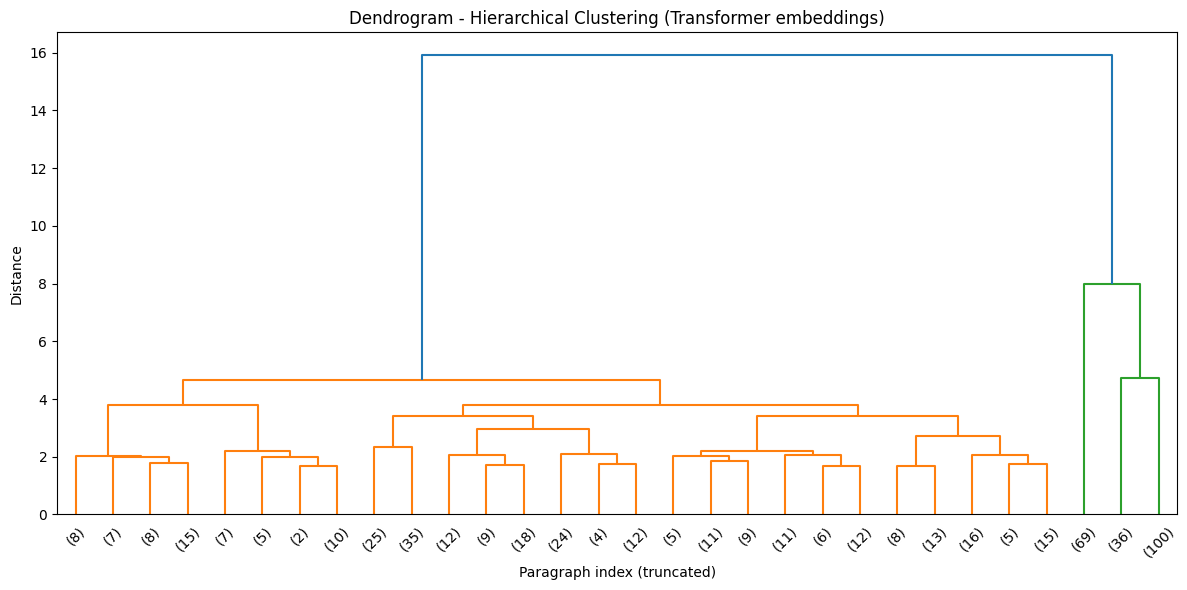

In [24]:

embed_model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = embed_model.encode(paragraphs, show_progress_bar=True)


Z2 = linkage(embeddings, method='ward')
plt.figure(figsize=(12, 6))
dendrogram(Z2, truncate_mode='lastp', p=30)
plt.title("Dendrogram - Hierarchical Clustering (Transformer embeddings)")
plt.xlabel("Paragraph index (truncated)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

In [12]:
import yake

# Extract keywords using YAKE
kw_extractor = yake.KeywordExtractor(
    lan="en", 
    n=1,  # Extract single-word keywords
    dedupLim=0.9, 
    top=10
)
keywords = kw_extractor.extract_keywords(text)

print("\nTop 5 Keywords (YAKE)")
for kw, score in keywords[:5]:
    print(f"{kw} (score: {score:.4f})")


Top 5 Keywords (YAKE)
Scholar (score: 0.0002)
Climate (score: 0.0003)
Google (score: 0.0003)
India (score: 0.0003)
full (score: 0.0004)


In [13]:
# Install yake
!pip install yake

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
